In [1]:
import networkx as nx
from dowhy import gcm
from dowhy.utils import plot, bar_plot
import warnings
warnings.filterwarnings("ignore")

c:\code\sriksml\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import networkx as nx
from dowhy import gcm
from dowhy.utils import plot, bar_plot

# causal modeling can be done in 2 ways - causal inference, causal discovery
# the below code uses causal inference, i.e. the relationships are created from observred data.
# while creating the below, in the context of Microservices and dependencies the path is inverted compared to the request flow.
causal_graph = nx.DiGraph([('www', 'Website'),
                           ('Auth Service', 'www'),
                           ('API', 'www'),
                           ('Customer DB', 'Auth Service'),
                           ('Customer DB', 'API'),
                           ('Product Service', 'API'),
                           ('Auth Service', 'API'),
                           ('Order Service', 'API'),
                           ('Shipping Cost Service', 'Product Service'),
                           ('Caching Service', 'Product Service'),
                           ('Product DB', 'Caching Service'),
                           ('Customer DB', 'Product Service'),
                           ('Order DB', 'Order Service')])

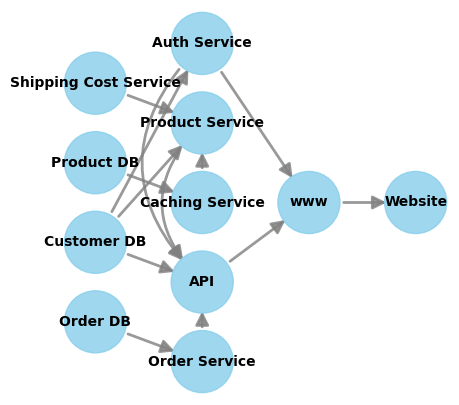

In [3]:
plot(causal_graph, figure_size=[5, 5])

In [4]:
from scipy.stats import halfnorm
causal_model = gcm.StructuralCausalModel(causal_graph)
for node in causal_graph.nodes:
    if len(list(causal_graph.predecessors(node))) > 0:
        # for all nodes with parents, we are using the linear regression model. 
        # in real world we need to use the appropriate model based on the data distribution.
        causal_model.set_causal_mechanism(node, gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
    else:
        # for all nodes without parents, we are using the half normal distribution.
        # in real world we need to use the appropriate model based on the data distribution.
        causal_model.set_causal_mechanism(node, gcm.ScipyDistribution(halfnorm))
        

In [5]:
import pandas as pd

# Observed latencies
normal_data = pd.read_csv("rca_microservice_architecture_latencies.csv")
normal_data.head()

,Product DB,Customer DB,Order DB,Shipping Cost Service,Caching Service,Product Service,Auth Service,Order Service,API,www,Website
0,0.553608,0.057729,0.153977,0.120217,0.122195,0.391738,0.399664,0.710525,2.103962,2.580403,2.971071
1,0.053393,0.239560,0.297794,0.142854,0.275471,0.545372,0.646370,0.991620,2.932192,3.804571,3.895535
2,0.023860,0.300044,0.042169,0.125017,0.152685,0.574918,0.672228,0.964807,3.106218,4.076227,4.441924
3,0.118598,0.478097,0.042383,0.143969,0.222720,0.618129,0.638179,0.938366,3.217643,4.043560,4.334924
4,0.524901,0.078031,0.031694,0.231884,0.647452,1.081753,0.388506,0.711937,2.793605,3.215307,3.255062


In [6]:
# fit causal model for validating the relationships
gcm.fit(causal_model, normal_data)

Fitting causal mechanism of node Order DB: 100%|██████████| 11/11 [00:00<00:00, 425.87it/s]   


In [7]:
gcm.evaluate_causal_model(causal_model, normal_data, compare_mechanism_baselines = True)

Test permutations of given graph: 100%|██████████| 50/50 [02:04<00:00,  2.48s/it]


CausalModelEvaluationResult(mechanism_performances={'Customer DB': MechanismPerformanceResult(), 'Shipping Cost Service': MechanismPerformanceResult(), 'Product DB': MechanismPerformanceResult(), 'Order DB': MechanismPerformanceResult(), 'Auth Service': MechanismPerformanceResult(), 'Caching Service': MechanismPerformanceResult(), 'Order Service': MechanismPerformanceResult(), 'Product Service': MechanismPerformanceResult(), 'API': MechanismPerformanceResult(), 'www': MechanismPerformanceResult(), 'Website': MechanismPerformanceResult()}, pnl_assumptions={'www': (1.0, False, 0.05), 'Website': (1.0, False, 0.05), 'Auth Service': (1.0, False, 0.05), 'API': (1.0, False, 0.05), 'Product Service': (0.0, True, 0.05), 'Order Service': (1.0, False, 0.05), 'Caching Service': (0.0, True, 0.05)}, graph_falsification=+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary               

In [8]:
outlier_data = pd.read_csv("rca_microservice_architecture_anomaly.csv")
outlier_data.head()

,Product DB,Customer DB,Order DB,Shipping Cost Service,Caching Service,Product Service,Auth Service,Order Service,API,www,Website
0,0.493145,0.180896,0.192593,0.197001,2.130865,2.48584,0.533847,1.132151,4.85583,5.522179,5.572588


In [9]:
print(outlier_data.iloc[0]['Website']-normal_data['Website'].mean())

2.0089554506421723


In [10]:
gcm.config.disable_progress_bars() # to disable print statements when computing Shapley values

median_attribs, uncertainty_attribs = gcm.confidence_intervals(
    gcm.fit_and_compute(gcm.attribute_anomalies,
                        causal_model,
                        normal_data,
                        target_node='Website',
                        anomaly_samples=outlier_data),
    num_bootstrap_resamples=10)

KeyboardInterrupt: 

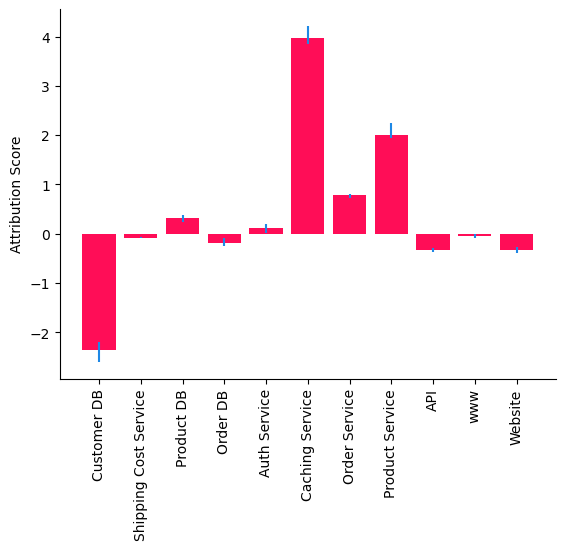

In [15]:
bar_plot(median_attribs, uncertainty_attribs, 'Attribution Score')